#### Jacob van Rosmalen s1007344

# Exercises

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
import pprint

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False,
                     'image.cmap':plt.cm.jet})


In [2]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

pprint.pp(lfp_data)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

{'lfp': array([ -24.765,  -78.975, -108.225, ...,    0.   ,    0.   ,    0.   ]),
 'sampling_rate': 1000.0}
Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


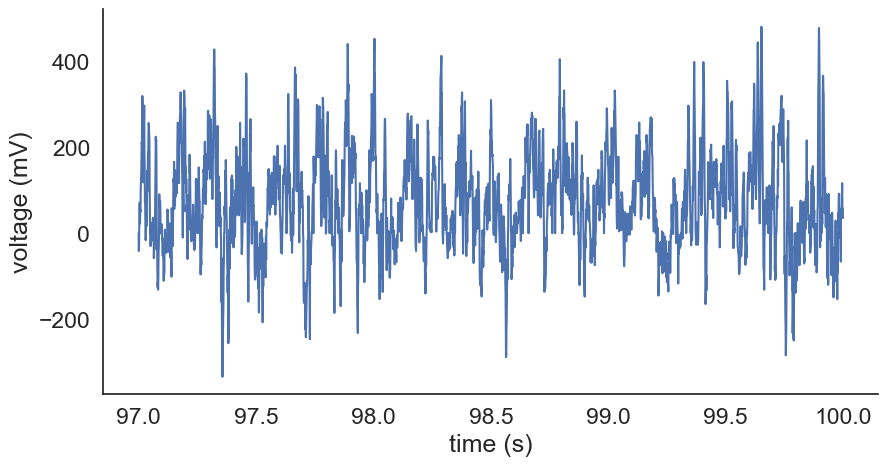

In [3]:
t_start = 97
t_end = 100
t_duration = t_end - t_start
steps_per_t = 1000
steps = t_duration * steps_per_t

plt.figure(figsize=(10,5))
plt.plot(np.linspace(t_start, t_end, steps), lfp[steps_per_t*t_start:steps_per_t*t_end])
plt.xlabel('time (s)')
plt.ylabel('voltage (mV)')
plt.show()

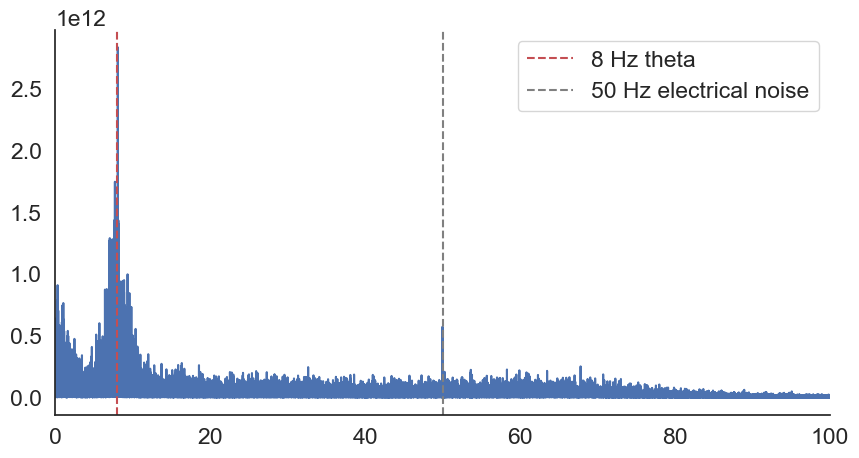

In [4]:
from scipy.fft import fft, fftfreq

n_samples = len(lfp)
sample_dt = 1. / sampling_rate

# we subtract the mean to get rid of the 0 frequency component in the spectrum
centered_lfp = lfp - np.mean(lfp)

transformed_signal = fft(centered_lfp) 

frequencies = fftfreq(n_samples,sample_dt) 

transformed_signal = transformed_signal[:n_samples//2]
frequencies = frequencies[:n_samples//2]

power = abs(transformed_signal)**2

plt.figure(figsize = (10,5))
plt.plot(frequencies,power)
plt.xlim([0,100]) # restrict to 
plt.axvline(x=8 ,c='r',linestyle='--',label='8 Hz theta')
plt.axvline(x=50 ,c='grey',linestyle='--',label='50 Hz electrical noise')

plt.legend()
plt.show()

In [5]:
from scipy.signal import butter
from scipy.signal import sosfilt
from ipywidgets import interact
import ipywidgets as widgets

def filter_signal(center_f, band_width, filter_order):
    low_f = max(1,center_f - band_width)
    high_f = center_f + band_width
    #define filter object
    filter = butter(filter_order,[low_f,high_f],
                    btype='band', 
                    output='sos', 
                    fs=sampling_rate)
                    
    #apply filter to lfp
    wideband_lfp = sosfilt(filter, lfp)
    return wideband_lfp

def plot_signal(center_f, band_width, filter_order):
    band_lfp = filter_signal(center_f, band_width, filter_order)

    plt.figure(figsize=(10,5))
    plt.plot(np.linspace(t_start, t_end, steps), band_lfp[steps_per_t*t_start:steps_per_t*t_end], label = 'filtered signal', color = 'red')
    plt.plot(np.linspace(t_start, t_end, steps), lfp[steps_per_t*t_start:steps_per_t*t_end],label='raw signal', alpha = 0.5)
    plt.xlabel('time (s)')
    plt.ylabel('voltage (mV)')
    plt.legend()
    plt.show()

center_f_widget = widgets.IntSlider(min=1, max=140, value=8, description='Center Freq.:')
bandwidth_widget = widgets.IntSlider(min=1, max=70, value=2, description='Bandwidth:')
filter_order_widget = widgets.IntSlider(min=1, max=10, value=5, description='Filter Order:')

interact(plot_signal, center_f=center_f_widget, band_width=bandwidth_widget, filter_order=filter_order_widget)

interactive(children=(IntSlider(value=8, description='Center Freq.:', max=140, min=1), IntSlider(value=2, desc…

<function __main__.plot_signal(center_f, band_width, filter_order)>

In [6]:
%timeit filter_signal(center_f_widget.value, bandwidth_widget.value, filter_order_widget.value)

5.52 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
%timeit filter_signal(center_f_widget.value, bandwidth_widget.value, 1)
%timeit filter_signal(center_f_widget.value, bandwidth_widget.value, 3)
%timeit filter_signal(center_f_widget.value, bandwidth_widget.value, 5)
%timeit filter_signal(center_f_widget.value, bandwidth_widget.value, 7)
%timeit filter_signal(center_f_widget.value, bandwidth_widget.value, 9)

4.05 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.35 ms ± 46.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.31 ms ± 63.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.87 ms ± 560 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.82 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


As the center frequency of the signal increases, the number of periods within the given time frame also increases. At lower bandwidths, the filtered signal reveals only a few distinct frequencies, whereas with higher bandwidths, the signal becomes more complex and similar to the raw signal. By increasing the filter order, the filtered signal more exclusively consists of the frequencies in the designated band. This can be clearly seen, as at lower orders (1 or 2), the signal becomes more jagged and like the raw signal, while at the higher orders, the signal becomes smoother and less noisy. This of course still depends on the range of the filtered band. The computation time increases with an increase in filter order and stays constant with changes in the other two variables.


## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

In [8]:
# making sure the data is correctly imported
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

pprint.pp(lfp_data)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

{'lfp': array([ -24.765,  -78.975, -108.225, ...,    0.   ,    0.   ,    0.   ]),
 'sampling_rate': 1000.0}
Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


Loaded 600.13 seconds of LFP at 1000.0 Hz


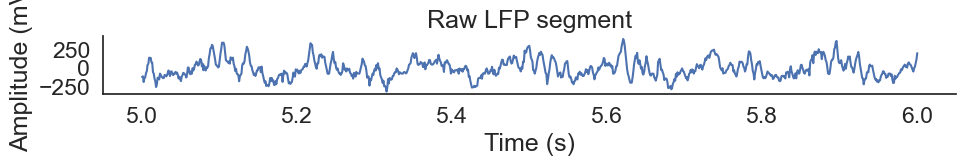

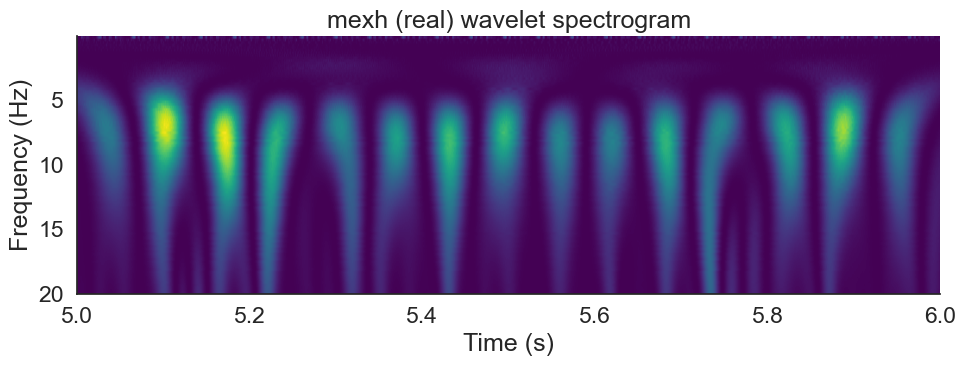

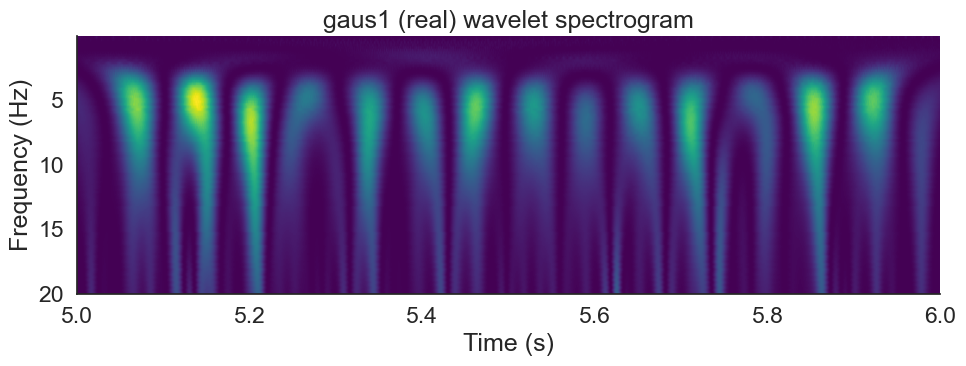

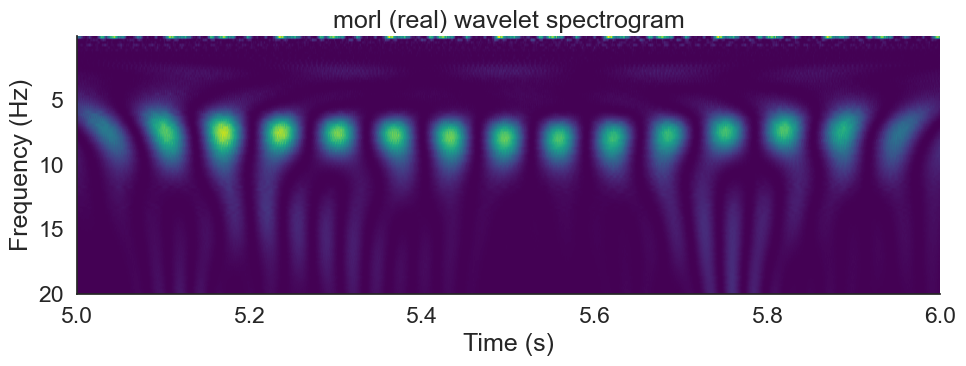

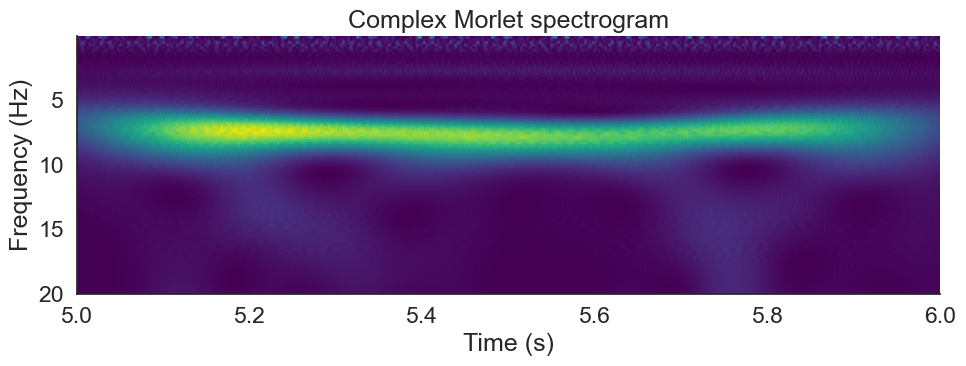

In [15]:
from pywt import wavelist
from pywt import scale2frequency
from pywt import cwt

with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)
lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']  # Hz
print(f'Loaded {len(lfp)/sampling_rate:.2f} seconds of LFP at {sampling_rate} Hz')

start = 5
end = 6
sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
sig = sig - np.mean(sig)

times = np.linspace(start, end, len(sig))

freq_min, freq_max, n_freqs = 0.1, 20, 100
frequencies = np.linspace(freq_min, freq_max, n_freqs)

# real wavelets
real_wavelets = ['mexh', 'gaus1', 'morl']
scales_dict = {}
for wavelet in real_wavelets:
    scales_dict[wavelet] = scale2frequency(wavelet, frequencies) * sampling_rate

cwt_results = {}
for wavelet in real_wavelets:
    cwtmatr, _ = cwt(
        sig,
        scales=scales_dict[wavelet],
        wavelet=wavelet,
        sampling_period=1.0/sampling_rate
    )
    cwt_results[wavelet] = cwtmatr

# complex wavelet
cmor_name = 'cmor1.5-1.0'
scales_cmor = scale2frequency(cmor_name, frequencies) * sampling_rate
cwt_cmplx, _ = cwt(
    sig,
    scales=scales_cmor,
    wavelet=cmor_name,
    sampling_period=1.0/sampling_rate
)

# plot raw signal
plt.figure(figsize=(10, 2))
plt.plot(times, sig)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('Raw LFP segment')
plt.tight_layout()
plt.show()

# plot spectrograms for real wavelets
for wavelet in real_wavelets:
    plt.figure(figsize=(10, 4))
    plt.imshow(
        np.abs(cwt_results[wavelet])**2,
        extent=[start, end, freq_max, freq_min],
        aspect='auto',
        cmap='viridis'
    )
    plt.title(f'{wavelet} (real) wavelet spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

# plot spectrogram for complex wavelet
plt.figure(figsize=(10, 4))
plt.imshow(
    np.abs(cwt_cmplx)**2,
    extent=[start, end, freq_max, freq_min],
    aspect='auto',
    cmap='viridis'
)
plt.title('Complex Morlet spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

The morlet wavelet is concentrated around 7-8 Hz while the other 2 wavelets are the highest around 4-5 Hz.
The complex morlet spectrogram shows a continuous band around 7-8 Hz, while the real morlet spectrogram shows nodes with constant spacing. The mexh and gaussian wavelets leak into other frequency bands, as seen from the smears across the vertical axis. The complex spectrogram is much narrower and more concentrated. This is probably due to the fact that the real morlet wavelet is based on a cosine and the complex one on a sine. Furthermore it also makes sense that the mexh and gauss wavelets look alike, because these wavelets are very similar in the their implementation. Mexican hat is essentially a variation of a gaussian (second derivative).

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/sleep_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [10]:
# Load data
with open('data/sleep_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)
lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']  # Hz
print(f'Loaded {len(lfp)/sampling_rate:.2f} seconds of LFP at {sampling_rate} Hz')

Loaded 1816.58 seconds of LFP at 1000.0 Hz


Text(0, 0.5, 'power (a.u.)')

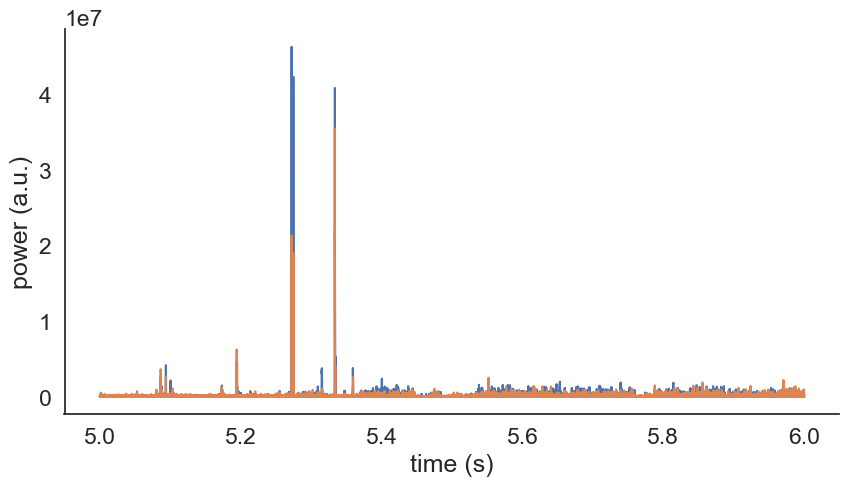

In [11]:
sig = lfp
sig = sig - np.mean(sig) # get rid of 0 frequency component

def compute_power(signal,sampling_rate,low_f=2,high_f=4):
    '''Takes lfp signal and sampling rate, returns instantaneous power in the specified band 
    (default is delta band 2-4 Hz)'''
    signal = signal - np.mean(signal) # get rid of 0 frequency component
    
    frequencies =  np.linspace(low_f,high_f,50)/sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet=wavelet, scales=scales,
                    sampling_period=1.0/sampling_rate)

    power = np.mean(abs(cwtmatr)**2,axis=0)

    return power
    
delta_power = compute_power(sig, sampling_rate, 2, 4)
theta_power = compute_power(sig, sampling_rate, 6, 10)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(start,end,len(delta_power)),delta_power)
plt.plot(np.linspace(start,end,len(theta_power)),theta_power)
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')

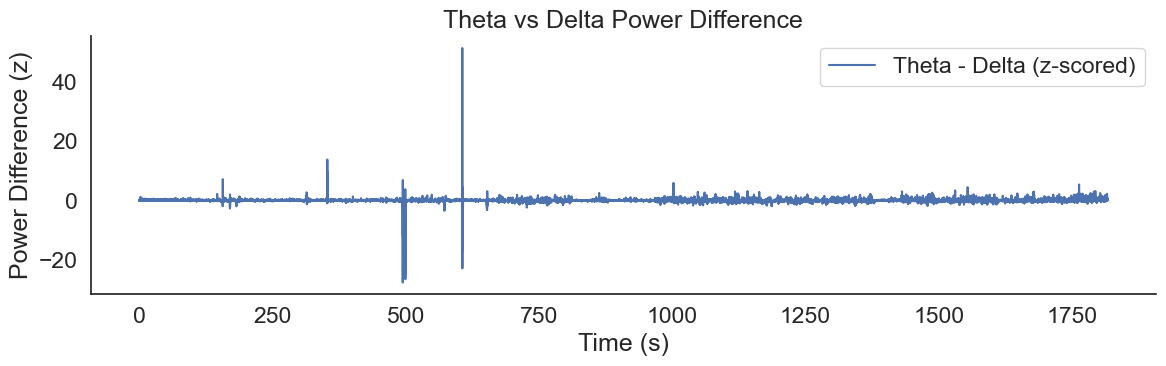

In [12]:
from scipy.stats import zscore
delta_z = zscore(delta_power)
theta_z = zscore(theta_power)

power_diff = theta_z - delta_z

# plot power difference over time
time = np.arange(len(lfp)) / sampling_rate
plt.figure(figsize=(12, 4))
plt.plot(time, power_diff, label='Theta - Delta (z-scored)')
plt.xlabel('Time (s)')
plt.ylabel('Power Difference (z)')
plt.title('Theta vs Delta Power Difference')
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# detect REM and nREM periods based on threshold
def detect_rem(power_diff, threshold = 0.2):
    is_rem = power_diff > threshold
    is_nrem = power_diff <= threshold
    return is_rem, is_nrem

def get_segment(mask, duration, sampling_rate):
    '''
    Returns indices of first continuous segment of given duration where mask is True.
    '''
    needed = int(duration * sampling_rate)
    runs = np.where(mask)[0]
    if len(runs) < needed:
        return runs[:needed]
    # find consecutive runs
    consec = np.split(runs, np.where(np.diff(runs) != 1)[0] + 1)
    for seg in consec:
        if len(seg) >= needed:
            return seg[:needed]
    return runs[:needed]


def plot_rem_lfp(threshold):
    is_rem, is_nrem = detect_rem(power_diff, threshold)
    print(f"Total duration of REM sleep:  {np.sum(is_rem)/sampling_rate} seconds")
    print(f"Total duration of nREM sleep: {np.sum(is_nrem)/sampling_rate} seconds")
    filtered_signal = lf.bandpass_filter(lfp,low_f=1,high_f=200, sampling_rate=sampling_rate)
    
    # Plot example REM vs nREM LFP
    seg_sec = 1  # in seconds
    rem_idx = get_segment(is_rem, seg_sec, sampling_rate)
    nrem_idx = get_segment(is_nrem, seg_sec, sampling_rate)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(time[rem_idx[0]:rem_idx[-1]],is_rem[rem_idx[0]:rem_idx[-1]])
    plt.title("Sleep state is_REM (REM=1 or NREM=0)")
    plt.subplot(4, 1, 2)
    plt.plot(time[rem_idx], filtered_signal[rem_idx])
    plt.title('Example REM LFP (1-200 Hz)')
    plt.xlabel('Time (s)')
    
    plt.subplot(4, 1, 3)
    plt.plot(time[nrem_idx[0]:nrem_idx[-1]],is_nrem[nrem_idx[0]:nrem_idx[-1]])
    plt.title("Sleep state is_nREM (REM=0 or NREM=1)")
    plt.subplot(4, 1, 4)
    plt.plot(time[nrem_idx], filtered_signal[nrem_idx])
    plt.title('Example nREM LFP (1-200 Hz)')
    plt.xlabel('Time (s)')
    plt.tight_layout()
    plt.show()

threshold_widget = widgets.FloatSlider(value=0.2,min=-2,max=2,step=0.05,
                                                          description='Test:', disabled=False, continuous_update=True,
                                                          orientation='horizontal',readout=True,readout_format='.2f',)

interact(plot_rem_lfp, threshold=threshold_widget)


interactive(children=(FloatSlider(value=0.2, description='Test:', max=2.0, min=-2.0, step=0.05), Output()), _d…

<function __main__.plot_rem_lfp(threshold)>

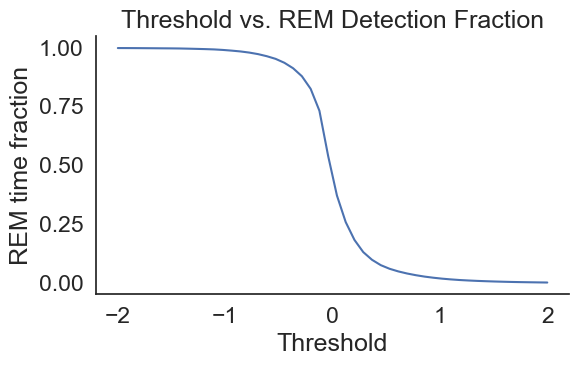

In [14]:
thresholds = np.linspace(-2, 2, 50)
fractions = [np.mean(power_diff > th) for th in thresholds]
plt.figure(figsize=(6, 4))
plt.plot(thresholds, fractions)
plt.xlabel('Threshold')
plt.ylabel('REM time fraction')
plt.title('Threshold vs. REM Detection Fraction')
plt.tight_layout()
plt.show()